# Language Model

## Step1:  Wiki corpus extract

下载zhwiki-20190401-pages-articles.xml.bz2。运行：

python WikiExtractor.py -b 500M -o extracted zhwiki-latest-pages-articles.xml.bz2

### 分割大小按500M进行提取，保存为wiki_00 wiki_01 widi_02 3个文件。单个文件提取时间大约20min：
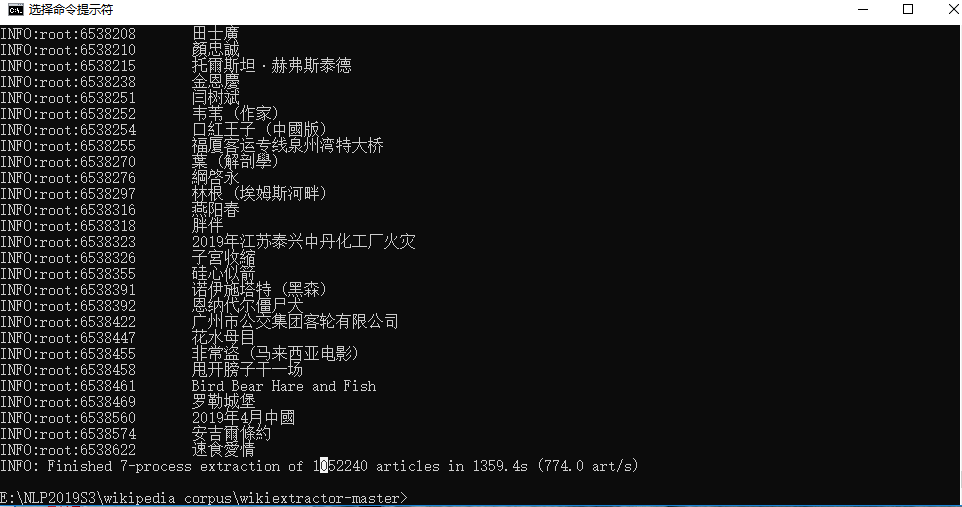

pip 安装 hanziconv后，win命令行在hanzi-convert命令行工具路径下执行：(注意，本作页考虑时间因素，仅用第一个500M分割的词汇库来进行建模)

python hanzi-convert -o wiki00_sim.txt wiki_00


因通过老师提供的hanziconv工具进行繁体转简体工作时间太长，转而用Opencc实现，并导出为wiki_00.zh.txt文件。

opencc -i ..\wikiextractor-master\extracted\AA\wiki_00 -o wiki00.zh.txt -c t2s.json

使用.py脚本完成对wiki00.zh.txt语句分割。导出wiki_jieba.txt。具体代码见WikiTextPurge.py

 ## Step2: Get all tokens from text

### 本例中database文件保存地址在本地，Github下载后请自行修改

In [1]:
database = 'D:/Python_Pycharm/NLPItems/wiki_jieba.txt'

In [2]:
import os
import codecs
import jieba

In [3]:
os.path.exists(database)

True

In [4]:
f=codecs.open(database,'r',encoding='utf-8')

In [5]:
s = f.readlines() 

In [6]:
f.close()

In [7]:
print (s[-4:-1])

['裘恩 教授 席      是 设于 英国伦敦大学 学院 中  四个 不同 科目 的 教授 席\r\n', '理察  裘恩于  年 至  年于 大学 学院 任 解剖学 教授  他 在  年 去世  留下 大部份 遗产  约    镑  予 大学 学院  以 推广 和 普及 现代 语文  特别 是 英文 及 英文 写作  和 自然科学 教育   大学 学院 以 他 遗产 设立 教授 席于 四个 不同 科目  故此 四 教授 席 被 命名 为 裘恩 教授 席以 纪念 裘恩 教授 的 贡献\r\n', '现时 四个 裘恩 教授 席 分别 为  裘恩 植物学 教授           裘恩 英语 及 文学 教授                 裘恩 法理学 教授          及 裘恩 物理学 教授\r\n']


In [8]:
import re

In [9]:
tokenlist=[]
for line in s:
    line=re.sub(r'\r\n','',line)
    if len(line.split())<=1: 
        continue
    for t in line.split():
        tokenlist.append(t)
   

In [10]:
len(tokenlist)

78350489

In [11]:
print (tokenlist[:100])

['数学', '是', '利用', '符号语言', '研究', '数量', '结构', '变化', '以及', '空间', '等', '概念', '的', '一门', '学科', '从', '某种', '角度看', '属于', '形式', '科学', '的', '一种', '数学', '透过', '抽象化', '和', '逻辑推理', '的', '使用', '由', '计数', '计算', '量度', '和', '对', '物体', '形状', '及', '运动', '的', '观察', '而', '产生', '数学家', '们', '拓展', '这些', '概念', '为了', '公式化', '新', '的', '猜想', '以及', '从', '选定', '的', '公理', '及', '定义', '中', '建立', '起', '严谨', '推导', '出', '的', '定理', '基础', '数学', '的', '知识', '与', '运用', '总是', '个人', '与', '团体', '生活', '中', '不可或缺', '的', '一环', '对', '数学', '基本概念', '的', '完善', '早', '在', '古埃及', '美索不达米亚', '及', '古印度', '内', '的', '古代', '数学', '文本']


## Step3: Get the statistics of words

In [12]:
from collections import Counter

In [13]:
from functools  import reduce

In [14]:
words_count=Counter(tokenlist)

In [15]:
wordtype=[w for w,f in words_count.most_common()] 

In [221]:
wordtype[-6:-1]

['文貌', '雄精', '公之文为', '必久', '梦阳']

In [17]:
V=len(wordtype)
print (V)      #获取总词汇数量

1185971


In [18]:
wordfrequency=[f for w,f in words_count.most_common()]

In [19]:
frequency_sum=sum(wordfrequency) 
print (1/frequency_sum)

1.2763162205662813e-08


## Step4: One grammar Model

In [21]:
def get_prob(word):
    eps=1/frequency_sum
    if word in words_count:
        prob=words_count[word]/frequency_sum
    else:
        prob=eps
    return prob
    

In [22]:
def product(number_sequence): return reduce(lambda x1,x2:x1*x2,number_sequence)

In [23]:
def language_model_one_grammar(sentence):
    words=list(jieba.cut(sentence));
    return product([get_prob(e) for e in words])


In [24]:
language_model_one_grammar('长征火箭下周发射')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\DELL\AppData\Local\Temp\jieba.cache
Loading model cost 0.624 seconds.
Prefix dict has been built succesfully.


4.443352032478915e-20

## Step5: Two grammar

### get joint probability

In [25]:
pair=[]
for index in range(len(tokenlist[:-2])):
    pair.append(''.join(tokenlist[index:index+2] )) #注意连接符必须与下面w1+w2中间的符号保持一致，这里为‘’空

In [26]:
pair_count=Counter(pair)

In [27]:
pair_count.most_common(10)

[('年月', 336774),
 ('月日', 255920),
 ('在年', 112278),
 ('于年', 105923),
 ('他的', 60608),
 ('中的', 58293),
 ('也是', 46969),
 ('的一个', 39987),
 ('上的', 36324),
 ('年的', 36310)]

In [44]:
pair_sum=len(pair)
print (pair_sum)

78350487


In [45]:
pair_count['中国共产党']

2

####  这里条件概率直接使用word统计数计算：
$$ Pr(w_2|w_1) = \frac {Pr(w_1，w_2)}  {Pr(w_1)}= \frac {C(w_1,w_2)} {C(w_1)} $$ 

#### 注意，如果不直接用word计算，如果w_1不存在，会出现 $ Pr(w_2|w_1)$ 大于1的情况。

这段代码被注释掉，仅供参考：

def get_joint_prob(w1,w2):
    eps=get_prob(w1)*get_prob(w2)
    
    if w1+w2 in pair:
        joint_prob=pair_count[w1+w2]/pair__sum
    else:
        joint_prob=eps
    return joint_prob
    

In [72]:
def get_conditi_prob(w1,w2):
    eps=1/pair_sum
    if w1+w2 in pair:
        conditi_prob=pair_count[w1+w2]/words_count[w1]
    else:
        conditi_prob=eps
    return conditi_prob
   

In [73]:
get_conditi_prob('中国','第一个')

0.0018796550832922158

In [77]:
def language_model_two_grammar(sentence):
    sentences_probility=1
    words=list(jieba.cut(sentence));
    for i , word in enumerate(words):
        if i==0:
            prob=get_prob(word)
        else:
            previous=words[i-1]
            prob=get_conditi_prob(previous,word)
        sentences_probility *=prob
    return sentences_probility

In [80]:
language_model_two_grammar('苏联是与中国第一个建交的国家')

7.441721468737951e-26

In [81]:
language_model_two_grammar('共产党是与中国第一个建交的国家')

4.72490251983362e-26

# Sentence Compare Test 

In [121]:
need_compared = [
    "这一只小猫真漂亮 这一只小猫真爱国",
    "今晚我去吃房子 今晚我去吃火锅",
    "中科院自动化研究所  中科院自动化植物所",
    "植树造林是保护生态环境的重要基础 植树造林是破坏生态环境的重要基础",
    "获得一架波音飞机订单  获得一个苹果手机订单",
]


### one_gram test

In [122]:
for s in need_compared:
    s1, s2 = s.split()
    p1, p2 = language_model_one_grammar(s1), language_model_one_grammar(s2)
    
    better = s1 if p1 > p2 else s2
    
    print('{} is more possible'.format(better))
    print('-'*4 + ' {} with probility {}'.format(s1, p1))
    print('-'*4 + ' {} with probility {}'.format(s2, p2))

这一只小猫真爱国 is more possible
---- 这一只小猫真漂亮 with probility 1.0429679593659839e-22
---- 这一只小猫真爱国 with probility 1.9176297804352968e-22
今晚我去吃火锅 is more possible
---- 今晚我去吃房子 with probility 3.505860853307015e-22
---- 今晚我去吃火锅 with probility 1.8094305494523687e-20
中科院自动化研究所 is more possible
---- 中科院自动化研究所 with probility 4.558425654791872e-15
---- 中科院自动化植物所 with probility 2.4706914118113128e-17
植树造林是保护生态环境的重要基础 is more possible
---- 植树造林是保护生态环境的重要基础 with probility 3.7634784675649304e-26
---- 植树造林是破坏生态环境的重要基础 with probility 2.144933905482317e-26
获得一个苹果手机订单 is more possible
---- 获得一架波音飞机订单 with probility 2.3183088620888865e-21
---- 获得一个苹果手机订单 with probility 2.4235815193385342e-20


### two_gram test

In [123]:
for s in need_compared:
    s1, s2 = s.split()
    p1, p2 = language_model_two_grammar(s1), language_model_two_grammar(s2)
    
    better = s1 if p1 > p2 else s2
    
    print('{} is more possible'.format(better))
    print('-'*4 + ' {} with probility {}'.format(s1, p1))
    print('-'*4 + ' {} with probility {}'.format(s2, p2))

这一只小猫真漂亮 is more possible
---- 这一只小猫真漂亮 with probility 1.1215368839007817e-21
---- 这一只小猫真爱国 with probility 1.8043247671924943e-26
今晚我去吃火锅 is more possible
---- 今晚我去吃房子 with probility 4.163545835600275e-21
---- 今晚我去吃火锅 with probility 3.177737140182575e-18
中科院自动化研究所 is more possible
---- 中科院自动化研究所 with probility 9.496087741239044e-16
---- 中科院自动化植物所 with probility 6.84023127892209e-22
植树造林是保护生态环境的重要基础 is more possible
---- 植树造林是保护生态环境的重要基础 with probility 2.155431987813444e-28
---- 植树造林是破坏生态环境的重要基础 with probility 1.5770268696378338e-28
获得一架波音飞机订单 is more possible
---- 获得一架波音飞机订单 with probility 1.1936418402622673e-14
---- 获得一个苹果手机订单 with probility 5.499195529024425e-21


# Good-Turing Smooth

#### get Nr for good-turing smooth

In [20]:
N=Counter(wordfrequency)

In [189]:
N[200]

116

In [223]:
r=words_count['文貌']
r,N[r]

(1, 598058)

In [156]:
import matplotlib.pyplot as plt
import math

In [139]:
%matplotlib inline

In [180]:
r,Nr= [r for r,Nr in N.most_common(600)],[Nr for r,Nr in N.most_common(600)]

r 与 Nr的关系呈长尾型，即出现次数越少的词数越大

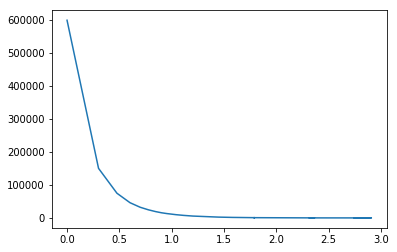

In [181]:
plt.plot([math.log(x,10) for x in r],Nr)

假设该词料中尚不可知的分词量总共有20万个。则定义：

In [193]:
N[0]=200000

In [205]:
def one_gram_turing_smooth(word):   
    r=words_count[word]
    print(r,N[r],N[r+1])
    if N[r+1]!=0:
        prob=(r+1)*N[r+1]/(N[r]*frequency_sum)
    else:
        prob=r/frequency_sum
    return prob
    

比较生僻词

In [214]:
one_gram_turing_smooth('鵹鹕') #源自山海经

0 200000 598058


3.8165556311971456e-08

In [215]:
get_prob('鵹鹕')

1.2763162205662813e-08

比较多频词

In [208]:
one_gram_turing_smooth('共产党') 

5010 1 0


6.39434426503707e-05

In [226]:
get_prob('共产党')

6.39434426503707e-05

比较低频词

In [225]:
one_gram_turing_smooth('文貌') 

1 598058 149974


6.401193491708412e-09

In [224]:
get_prob('文貌')

1.2763162205662813e-08

## 总结：应用图灵平滑后，没有出现的词汇概率会提升。而出现次数低的词汇分配的概率会降低。